[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/rag/rag_mongodb_llama3_huggingface_open_source.ipynb) 

# Implementing RAG pipelines with MongoDB and Llama3 and Open models From Hugging Face

This notebook is designed to demonstrate how to integrate and utilize Hugging Face's open-source models, specifically Llama3, with MongoDB to implement Retrieval-Augmented Generation (RAG) pipelines for enhanced question answering capabilities.

The process involves preparing a dataset of arXiv papers, transforming their data for effective retrieval, setting up a MongoDB database with vector search capabilities, and using llama3 model for generating answers based on the retrieved documents.

Key Highlights:
- Usage of Hugging Face open-source models and MongoDB for creating RAG pipelines.
- Steps include dataset preparation, database setup, data ingestion, and query processing.
- Detailed guidance on setting up MongoDB collections and vector search indexes.
- Integration with the Llama3 model from Hugging Face for answering complex queries.

Follow the following instruction to set up a MongoDB database and enable vector search:
1. [Register a free Atlas account](https://account.mongodb.com/account/register?utm_campaign=devrel&utm_source=community&utm_medium=cta&utm_content=GitHub%20Cookbook&utm_term=richmond.alake)
 or sign in to your existing Atlas account.

2. [Follow the instructions](https://www.mongodb.com/docs/atlas/tutorial/deploy-free-tier-cluster/)
 (select Atlas UI as the procedure) to deploy your first cluster, which distributes your data across multiple servers for improved performance and redundancy.
 
 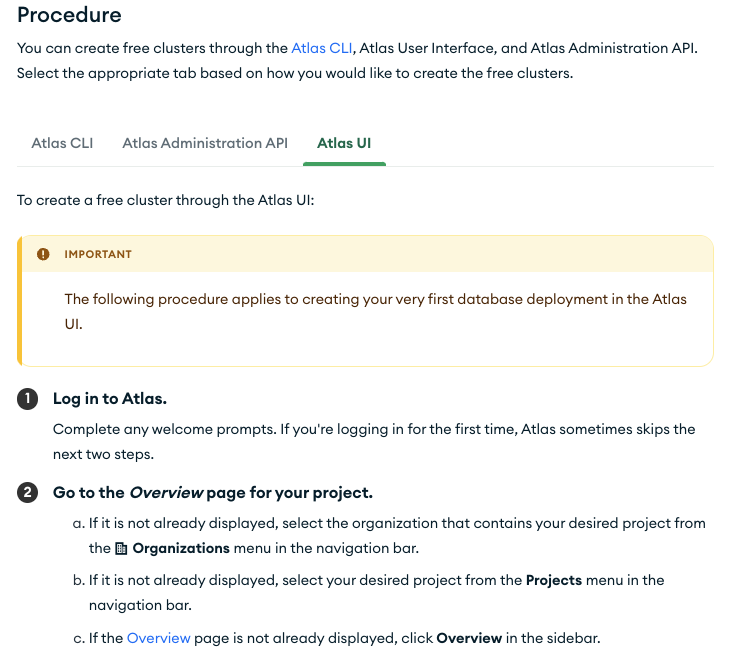

3. For a free Cluser, be sure to select "Shared" option when creating your new cluster. See image below for details

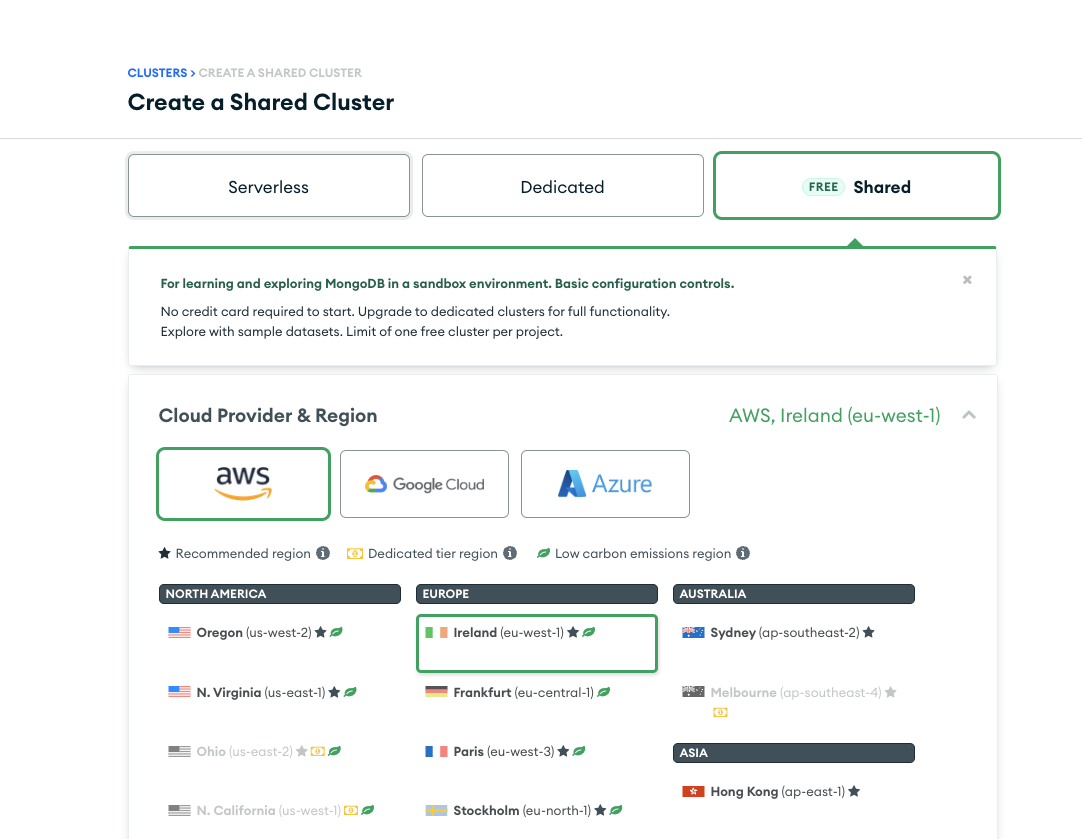

4. Create the database: `knowledge_base`, and collection `research_papers`



## Import Libraries

Import libaries into development environment

In [ ]:
!pip install datasets pandas pymongo sentence_transformers
!pip install -U transformers
# Install the library below if using GPU, if using CPU, please comment out below
!pip install accelerate

## Dataset Loading and Preparation

Load the dataset from HuggingFace.

Only using the first 100 datapoint for demo purposes.

In [ ]:
# Load Dataset
from datasets import load_dataset
import pandas as pd
import os

# Make sure you have an Hugging Face token(HF_TOKEN) in your development environemnt before runing the code below
# How to get a token: https://huggingface.co/docs/hub/en/security-tokens
# Dataset Location: https://huggingface.co/datasets/MongoDB/subset_arxiv_papers_with_embeddings
os.environ["HF_TOKEN"] = "place_hugging_face_access_token here" # Do not use this in production environment, use a .env file instead

dataset = load_dataset("MongoDB/subset_arxiv_papers_with_embeddings")

# Convert the dataset to a pandas dataframe
dataset_df = pd.DataFrame(dataset['train'])

dataset_df.head(5)

In [ ]:
# Data Preparation

# Only use the first 100 for demo and POC purposes
dataset_df = dataset_df.head(100)

# Remove the embedding from each data point in the dataset as we are going to create new embeddings with an open source embedding model from Hugging Face
dataset_df = dataset_df.drop(columns=['embedding'])
dataset_df.head(5)

## Generate Embeddings

In [5]:
from sentence_transformers import SentenceTransformer

# https://huggingface.co/thenlper/gte-large
embedding_model = SentenceTransformer('thenlper/gte-large')

def get_embedding(text: str) -> list[float]:
  if not text.strip():
      print("Attempted to get embedding for empty text.")
      return []

  embedding = embedding_model.encode(text)

  return embedding.tolist()

dataset_df['embedding'] = dataset_df.apply(lambda x: get_embedding(x['title'] + " " + x['authors'] + " " + x['abstract']), axis=1)

dataset_df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,embedding
0,704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...","[-0.0073745595291256905, -0.03725249320268631,..."
1,704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]","[0.005753430537879467, 0.007056022062897682, 0..."
2,704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]","[-0.0057186526246368885, 0.022108040750026703,..."
3,704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]","[-0.02010205015540123, -0.0021757606882601976,..."
4,704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]","[-0.0027832775376737118, 0.014300416223704815,..."


## Database and Collection Setup

Complete the steps below if not already carried out previously.
Creating a database and collection within MongoDB is made simple with MongoDB Atlas.

1. [Register a free Atlas account](https://account.mongodb.com/account/register?utm_campaign=devrel&utm_source=community&utm_medium=cta&utm_content=GitHub%20Cookbook&utm_term=richmond.alake)
 or sign in to your existing Atlas account.

2. [Follow the instructions](https://www.mongodb.com/docs/atlas/tutorial/deploy-free-tier-cluster/)
 (select Atlas UI as the procedure)  to deploy your first cluster.

3. Create the database: `knowledge_base`.
4. Within the database` knowledge_base`, create the following collections: `research_papers`
5. Create a
[vector search index](https://www.mongodb.com/docs/atlas/atlas-vector-search/create-index/#procedure)
 named `vector_index` for the `research_papers` collection. This index enables the RAG application to retrieve records as additional context to supplement user queries via vector search. Below is the JSON definition of the data collection vector search index.


 Below is a snipper of what the vector search index definition should looks like:
 ```
    {
      "fields": [
        {
          "numDimensions": 1024,
          "path": "embedding",
          "similarity": "cosine",
          "type": "vector"
        }
      ]
    }
  ```

In [6]:
import pymongo

def get_mongo_client(mongo_uri):
    """Establish connection to the MongoDB."""
    try:
        client = pymongo.MongoClient(mongo_uri, appname="devrel.content.python")
        print("Connection to MongoDB successful")
        return client
    except pymongo.errors.ConnectionFailure as e:
        print(f"Connection failed: {e}")
        return None

# Ensure connection strings are placed securely in environment variables and not disclosed in production environments.
mongo_uri = "mongodb...pName=Cluster0"  # Placeholder, replace with your connection string or actual environment variable fetching method.

if not mongo_uri:
    print("MONGO_URI not set in environment variables.")

mongo_client = get_mongo_client(mongo_uri)

# Ingest data into MongoDB
db = mongo_client['knowledge_base']
collection = db['research_papers']


Connection to MongoDB successful


In [7]:
# Delete any existing records in the collection
collection.delete_many({})

DeleteResult({'n': 100, 'electionId': ObjectId('7fffffff000000000000001f'), 'opTime': {'ts': Timestamp(1713636955, 100), 't': 31}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1713636955, 100), 'signature': {'hash': b'J\x17\x95:(\x9f\xb4\x96\xcdv:"\xbc\x0c)\x98\xd3\tq\x89', 'keyId': 7320226449804230662}}, 'operationTime': Timestamp(1713636955, 100)}, acknowledged=True)

## Data Ingestion

In [8]:
documents = dataset_df.to_dict('records')
collection.insert_many(documents)

print("Data ingestion into MongoDB completed")

Data ingestion into MongoDB completed


## Vector Search

In [9]:

def vector_search(user_query, collection):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
    user_query (str): The user's query string.
    collection (MongoCollection): The MongoDB collection to search.

    Returns:
    list: A list of matching documents.
    """

    # Generate embedding for the user query
    query_embedding = get_embedding(user_query)

    if query_embedding is None:
        return "Invalid query or embedding generation failed."

    # Define the vector search pipeline
    vector_search_stage = {
        "$vectorSearch": {
            "index": "vector_index",
            "queryVector": query_embedding,
            "path": "embedding",
            "numCandidates": 150,  # Number of candidate matches to consider
            "limit": 4  # Return top 4 matches
        }
    }

    unset_stage = {
        "$unset": "embedding"  # Exclude the 'embedding' field from the results
    }

    project_stage = {
        "$project": {
            "_id": 0,  # Exclude the _id field
            "fullplot": 1,  # Include the plot field
            "title": 1,  # Include the title field
            "genres": 1, # Include the genres field
            "score": {
                "$meta": "vectorSearchScore"  # Include the search score
            }
        }
    }

    pipeline = [vector_search_stage, unset_stage, project_stage]

    # Execute the search
    results = collection.aggregate(pipeline)
    return list(results)

In [10]:
def get_search_result(query, collection):

  get_knowledge = vector_search(query, collection)

  search_result = ''
  for result in get_knowledge:
      search_result += f"Title: {result.get('title', 'N/A')}, Plot: {result.get('abstract', 'N/A')}\n"

  return search_result

## Handling User Queries

In [11]:
# Conduct query with retrival of sources
query = "Get me papers on Artificial Intelligence?"
source_information = get_search_result(query, collection)
combined_information = f"Query: {query}\nContinue to answer the query by using the Search Results:\n{source_information}."
messages = [
    {"role": "system", "content": "You are a research assitant!"},
    {"role": "user", "content": combined_information},
]
print(messages)

[{'role': 'system', 'content': 'You are a research assitant!'}, {'role': 'user', 'content': 'Query: Get me papers on Artificial Intelligence?\nContinue to answer the query by using the Search Results:\n.'}]


## Loading and Using Llama3

In [12]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3.1-8B-Instruct")
# CPU Enabled uncomment below 👇🏽
# model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3.1-8B-Instruct")
# GPU Enabled use below 👇🏽
model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3.1-8B-Instruct", torch_dtype=torch.bfloat16, device_map="auto")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


I'd be happy to help you with that. Here are some research papers on Artificial Intelligence that I found using a search engine:

**1. "Deep Learning" by Yann LeCun, Yoshua Bengio, and Geoffrey Hinton (2015)**

This paper is a seminal work on deep learning, a subset of AI that involves training neural networks to perform tasks such as image recognition, speech recognition, and natural language processing.

Source: LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. Nature, 521(7553), 436-444. doi: 10.1038/nature14539

**2. "AlphaGo: Mastering the Game of Go with Deep Neural Networks and Tree Search" by Demis Hassabis, Shane Legg, and Joseph Modayil (2015)**

This paper describes the development of AlphaGo, a computer program that uses AI to play the game of Go. AlphaGo was able to defeat a human world champion in a five-game match, marking a significant milestone in AI research.

Source: Hassabis, D., Legg, S., & Modayil, J. (2015). AlphaGo: Mastering the
